In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 4)

In [3]:
#Downloading the dataset
!gdown 1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg

Downloading...
From: https://drive.google.com/uc?id=1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg
To: /content/mobilesales.xlsx
100% 13.7k/13.7k [00:00<00:00, 29.9MB/s]


In [4]:
mobile_sales = pd.read_excel("mobilesales.xlsx")

In [5]:
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


In [6]:
mobile_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    217 non-null    datetime64[ns]
 1   Sales   198 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.5 KB


In [7]:
#Make the timestamp column index
mobile_sales.set_index("DATE",inplace=True)

In [8]:
mobile_sales.head()

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0


#Imputing Missing Values

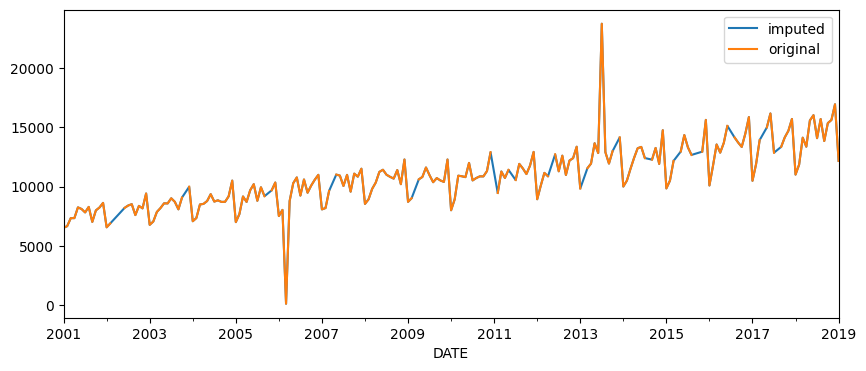

In [9]:
#Linear Interpolation
mobile_sales.Sales.interpolate(method="linear").plot(label="imputed")
mobile_sales.Sales.plot(label="original")
plt.legend()

In [10]:
mobile_sales.Sales = mobile_sales.Sales.interpolate(method="linear")

#Handling ANomalies

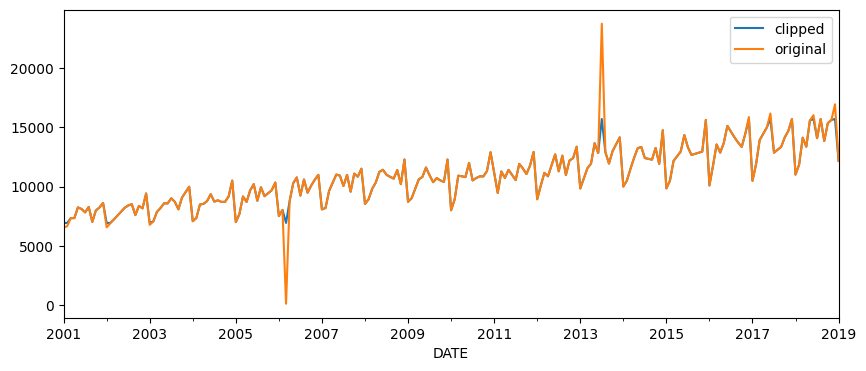

In [11]:
mobile_sales.Sales.clip(lower = mobile_sales.Sales.quantile(0.025),upper = mobile_sales.Sales.quantile(0.975)).plot(label="clipped")
mobile_sales.Sales.plot(label="original")
plt.legend()

In [12]:
mobile_sales.Sales = mobile_sales.Sales.clip(lower = mobile_sales.Sales.quantile(0.025),upper = mobile_sales.Sales.quantile(0.975))

In [13]:
mobile_sales.Sales.rolling(window=3).mean()

DATE
2001-01-01             NaN
2001-02-01             NaN
2001-03-01     7061.866667
2001-04-01     7196.933333
2001-05-01     7634.666667
                  ...     
2018-09-01    14538.333333
2018-10-01    14962.000000
2018-11-01    14934.666667
2018-12-01    15555.733333
2019-01-01    14492.066667
Name: Sales, Length: 217, dtype: float64

In [14]:
#Centered MA
mobile_sales.Sales.rolling(window=3,center=True).mean()

DATE
2001-01-01             NaN
2001-02-01     7061.866667
2001-03-01     7196.933333
2001-04-01     7634.666667
2001-05-01     7892.000000
                  ...     
2018-09-01    14962.000000
2018-10-01    14934.666667
2018-11-01    15555.733333
2018-12-01    14492.066667
2019-01-01             NaN
Name: Sales, Length: 217, dtype: float64

#Train Test Split

In [15]:
train_x = mobile_sales[mobile_sales.index<mobile_sales.index[-12]]
test_x = mobile_sales[mobile_sales.index>=mobile_sales.index[-12]]
display(train_x.tail(2))
display(test_x.head(2))

,Sales
DATE,
2017-12-01,15701.2
2018-01-01,11005.0


,Sales
DATE,
2018-02-01,11852.0
2018-03-01,14123.0


In [16]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

In [17]:
import statsmodels.api as sm

def adf_test(dataset):
   pvalue = sm.tsa.stattools.adfuller(dataset)[1]
   if pvalue <= 0.05:
      print('Sequence is stationary')
   else:
      print('Sequence is not stationary')

adf_test(mobile_sales.Sales)

Sequence is not stationary


#AR Model

In [18]:
train_x.head()

,Sales
DATE,
2001-01-01,6926.8
2001-02-01,6926.8
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0


In [19]:
test_x.head()

,Sales
DATE,
2018-02-01,11852.0
2018-03-01,14123.0
2018-04-01,13360.0
2018-05-01,15576.0
2018-06-01,15701.2


In [20]:
adf_test(train_x.Sales)

Sequence is not stationary


In [21]:
train_x_st = train_x.copy()
train_x_st.Sales = train_x_st.Sales.diff(1)
train_x_st.dropna(inplace=True)
adf_test(train_x_st.Sales)

Sequence is stationary


In [22]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
model = SARIMAX(train_x_st.Sales, order=(1, 0, 0)) # order = (p,d,q)
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x['pred'].head(20)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-23-2a317a49d729>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['pred'] = model.forecast(steps=12)


DATE
2018-02-01    1721.700409
2018-03-01    -631.202312
2018-04-01     231.408645
2018-05-01     -84.838030
2018-06-01      31.102950
2018-07-01     -11.402828
2018-08-01       4.180455
2018-09-01      -1.532620
2018-10-01       0.561883
2018-11-01      -0.205995
2018-12-01       0.075521
2019-01-01      -0.027687
Name: pred, dtype: float64

In [24]:
# Integrate !!

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

<ipython-input-24-b273202e7dca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]


In [25]:
test_x['pred'].head(20)

DATE
2018-02-01    12726.700409
2018-03-01    12095.498097
2018-04-01    12326.906742
2018-05-01    12242.068711
2018-06-01    12273.171661
2018-07-01    12261.768833
2018-08-01    12265.949288
2018-09-01    12264.416668
2018-10-01    12264.978550
2018-11-01    12264.772555
2018-12-01    12264.848076
2019-01-01    12264.820389
Name: pred, dtype: float64

MAE : 2291.462
RMSE : 2564.679
MAPE: 0.153


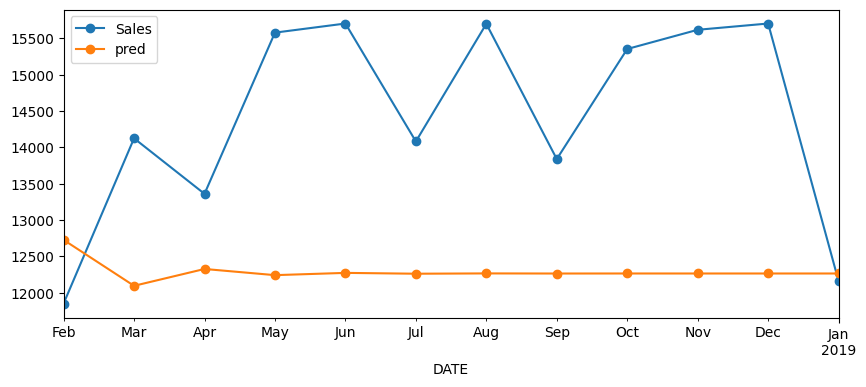

In [26]:
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-27-c2bd809dd41e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['pred'] = model.forecast(steps=12)
<ipython-input-27-c2bd809dd41e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

MAE : 1629.392
RMSE : 1866.038
MAPE: 0.109


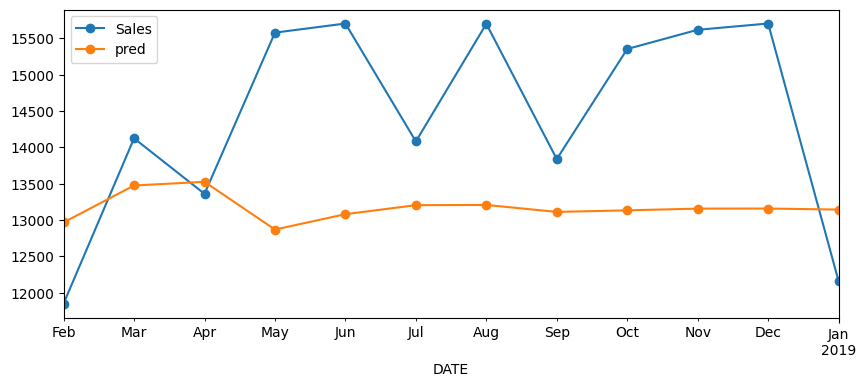

In [27]:
model = SARIMAX(train_x_st.Sales, order=(3, 0, 0)) # order = (p,d,q)
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x['pred'].head(20)

# Integrate !!

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])




#MA model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-29-88b8805c34bb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['pred'] = model.forecast(steps=12)
<ipython-input-29-88b8805c34bb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

MAE : 1322.12
RMSE : 1519.791
MAPE: 0.09


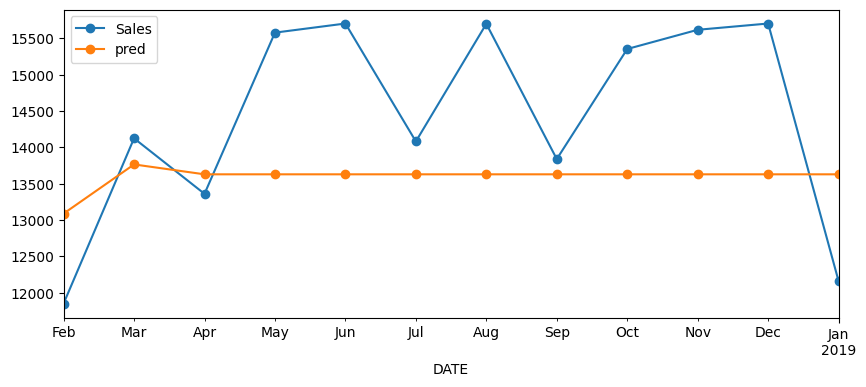

In [29]:
model = SARIMAX(train_x_st.Sales, order=(0, 0, 3)) # order = (p,d,q)
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x['pred'].head(20)

# Integrate !!

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

#ARMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
<ipython-input-30-d6ae1056af48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['pred'] = model.forecast(steps=

MAE : 1292.998
RMSE : 1459.97
MAPE: 0.088


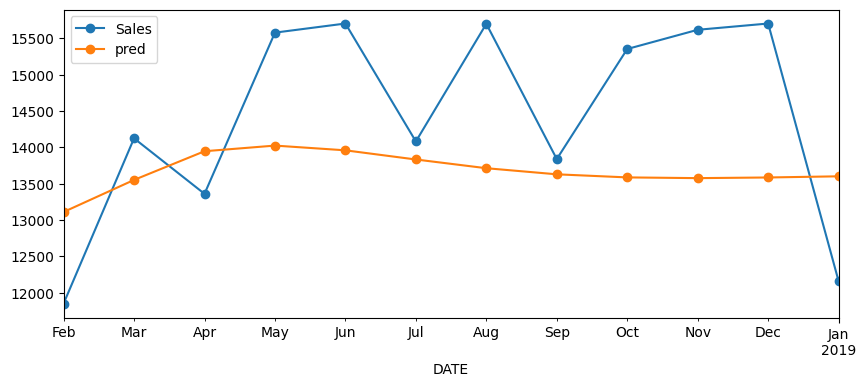

In [30]:
model = SARIMAX(train_x_st.Sales, order=(3, 0, 2)) #3 past values and 2 past errors
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x['pred'].head(20)

# Integrate !!

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

<Axes: xlabel='DATE'>

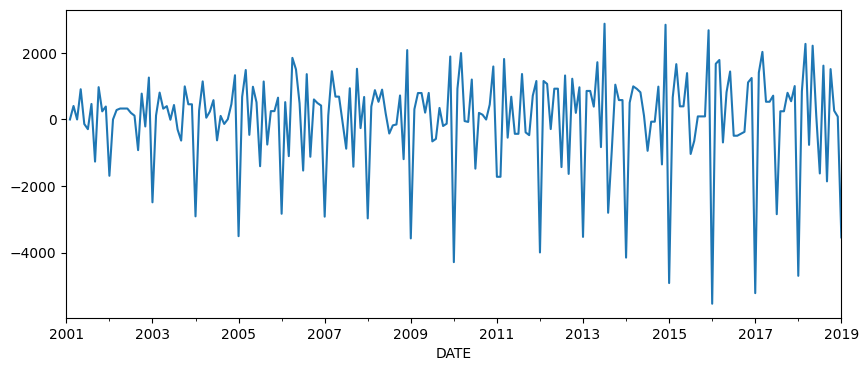

In [31]:
mobile_sales.Sales.diff(1).plot()

#Arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
<ipython-input-32-7af3eb4b0688>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['pred'] = model.forecast(steps=

MAE : 1291.764
RMSE : 1461.328
MAPE: 0.088


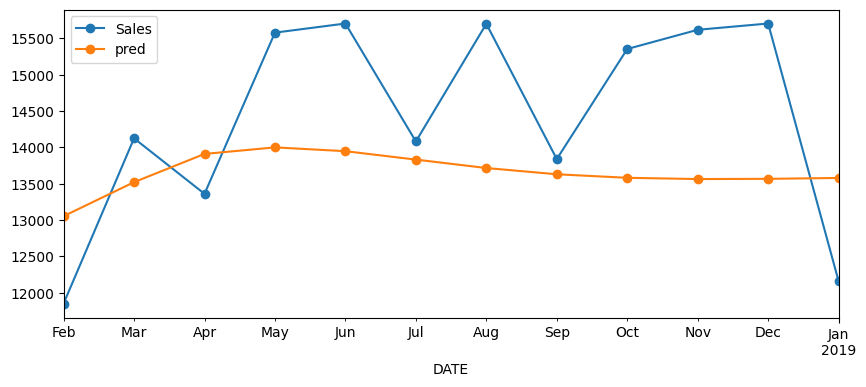

In [32]:
model = SARIMAX(train_x.Sales, order=(3, 1, 2)) #3 past values and 2 past errors and differencing 1 time
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x['pred'].head(20)

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

#Sarima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-34-cfe3b921f697>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['pred'] = model.forecast(steps=12)


MAE : 491.858
RMSE : 646.374
MAPE: 0.034


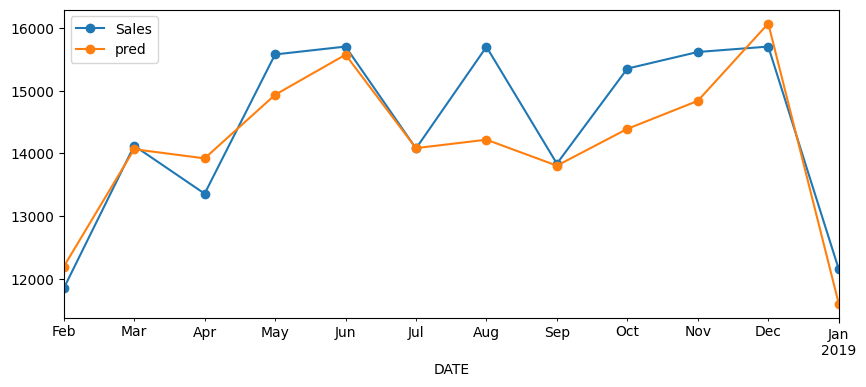

In [34]:
model = SARIMAX(train_x.Sales, order=(3, 1, 3), seasonal_order=(1,1,1,12))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

#Confidence Interval

In [35]:
model.get_forecast(steps=12).conf_int(0.05).values

array([[10645.04214287, 13750.82875255],
       [12471.03248913, 15663.73814444],
       [12317.16423102, 15526.34827185],
       [13314.19032837, 16552.48528297],
       [13910.32674254, 17233.31539724],
       [12419.37211022, 15749.63543577],
       [12521.39093952, 15917.04580084],
       [12088.10752489, 15523.35096874],
       [12666.26361926, 16116.94762091],
       [13075.18142608, 16599.50575195],
       [14297.04417431, 17839.08355016],
       [ 9822.51175765, 13400.52396559]])

<ipython-input-36-eb4b22dc2b72>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x[['lower', 'upper']] = model.get_forecast(steps=12).conf_int(0.05).values
<ipython-input-36-eb4b22dc2b72>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x[['lower', 'upper']] = model.get_forecast(steps=12).conf_int(0.05).values


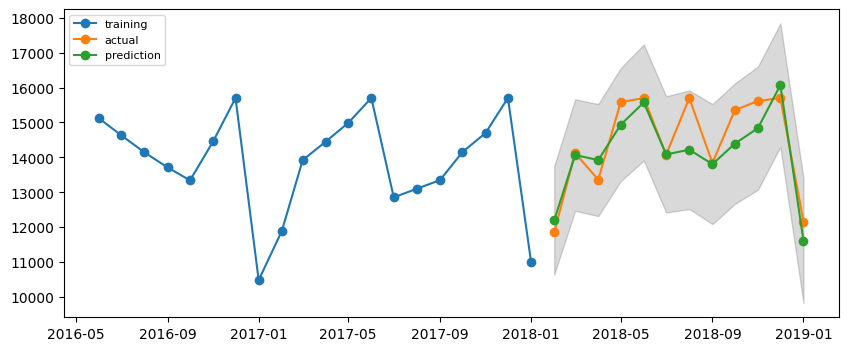

In [36]:
test_x[['lower', 'upper']] = model.get_forecast(steps=12).conf_int(0.05).values
plt.plot(train_x['Sales'][-20:], '-o', label='training')
plt.plot(test_x['Sales'], '-o', label='actual')
plt.plot(test_x['pred'], '-o', label='prediction')
plt.fill_between(test_x.index, test_x['lower'], test_x['upper'],
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

<ipython-input-39-86c7d06e33e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x[['lower', 'upper']] = model.get_forecast(steps=12).conf_int(0.01).values


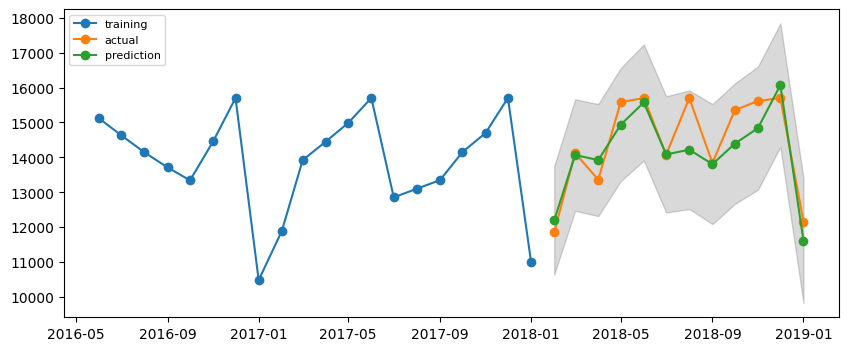

In [39]:
test_x[['lower', 'upper']] = model.get_forecast(steps=12).conf_int(0.01).values
plt.plot(train_x['Sales'][-20:], '-o', label='training')
plt.plot(test_x['Sales'], '-o', label='actual')
plt.plot(test_x['pred'], '-o', label='prediction')
plt.fill_between(test_x.index, test_x['lower'], test_x['upper'],
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

#Change Points

In [40]:
from IPython.display import Image
Image(url='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/007/752/original/illustration_of_change_point_detectopn_via_sliding-window.gif?1658421673')

<Axes: xlabel='DATE'>

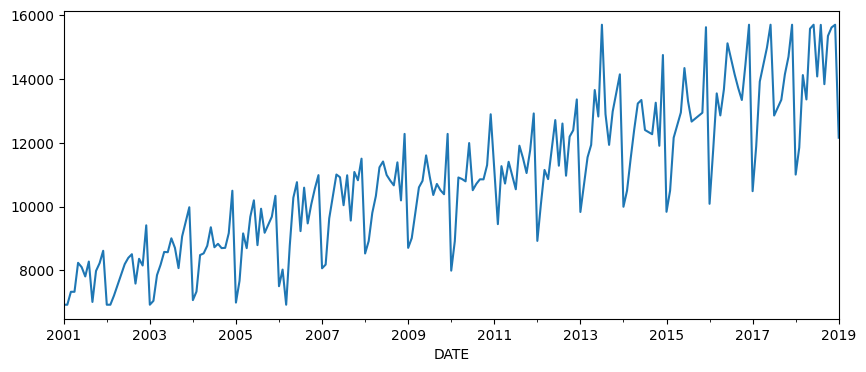

In [43]:
mobile_sales.Sales.plot()

In [41]:
def plot_changepoints(signal, changepoints):
  for cp in changepoints:
    plt.axvline(x=cp, color='#FA8072')
  plt.plot(signal, '-*', label='signal')

  start = 0
  trends = np.array([])
  for i in changepoints:
    x = np.arange(start, i)
    y = signal[start:i]
    l1 = np.polyfit(x, y, deg=1)
    trend = x*l1[0] + l1[1]
    trends = np.append(trends, trend)
    start = i

  plt.plot(trends, label='trend')
  plt.legend()
  plt.show()

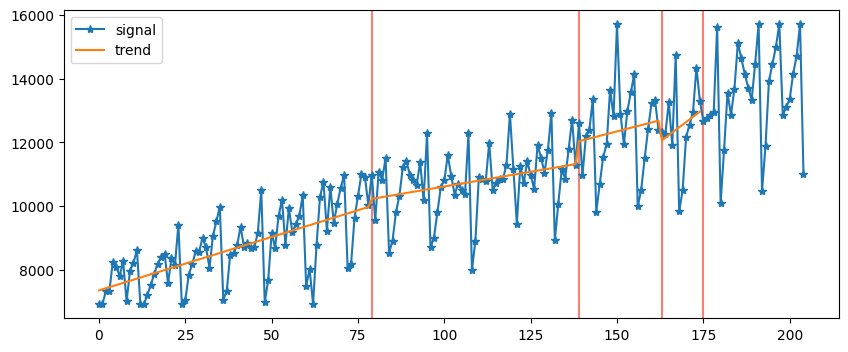

In [42]:
signal = train_x.Sales # Stationarise for mean as cost function
window=60
def get_slope(y):
  return np.polyfit(np.arange(len(y)), y, deg=1)[0]

changepoints = signal.loc[abs(signal.rolling(window, center=True).apply(get_slope).diff()) > 7.5].index
# converting to index from dates
temp = signal.reset_index()
changepoints = temp.loc[temp['DATE'].isin(changepoints)].index.tolist()

plot_changepoints(signal.values, changepoints)